<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [293]:
import numpy as np
import pandas as pd

In [294]:
 # Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L = 1.5  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3  # устьевого штуцера
r_GU = 3  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 60  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]

In [295]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []

In [296]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_R = 0.1

In [297]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [298]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [299]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R

In [300]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = 0.0000091 #k_S*X_G*M_R3

In [301]:
# Расчёт динамики

# Начальные условия

M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 0
p_3 = p_L + gamma * h_4
epsilon = 0.01 * p_3
q_L = 0

# Сегмент напорной характеристики
i = 1
k = 25000


In [302]:
# Начало расчёта
for _k in range(k):

    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
    __p_3 = p_4 + gamma * h_4
    # Балансировка притока по начальным условиям
    while abs(p_3 - __p_3) > epsilon:
        p_3 = (1-M_q)*p_3 + M_q*__p_3
        q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
        p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
        __p_3 = p_4 + gamma * h_4

    p_3 = __p_3

    p_8 =p_L + gamma*r_U*q_L

    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
    q_N = max(q_N, 0)

    if  q_N > w*q_0*q_Pump[i]:
      i-=1
      i = max(i, 0)
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)

    if  q_N < w*q_0*q_Pump[i+1]:
      i+=1
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)



    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_R3*(p_G0 - p_3))
    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))

    # Шаг по Эйлеру

    p_1 = p_2 - r_1*q
    p_5 = p_8 + gamma*(H_N+r_R*q_N)

    _p_1.append(p_1)
    _p_3.append(p_3)
    _p_4.append(p_4)
    _p_8.append(p_8)
    _q_N.append(q_N)
    __q.append(q)
    _h_4.append(h_4)
    _u.append(w)

    p_2 = p_2 + (0.0001/0.4)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (0.0001/0.01)*(q-q_N)
    q_L = q_L + (0.0001/0.001)*(q_N-q_L)



In [303]:

x = np.linspace(0, 1.5, k)
x

array([0.00000000e+00, 6.00024001e-05, 1.20004800e-04, ...,
       1.49988000e+00, 1.49994000e+00, 1.50000000e+00])

In [304]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u, 'x': x,
                   'p_4': _p_4, 'p_8': _p_8})

In [305]:
df

,q_N,p_3,p_1,q,h_4,u,x,p_4,p_8
0,85.119186,13.590000,21.650000,0.000000,1500.000000,1,0.00000,1.500000,1.500000
1,84.682898,13.583139,21.650000,0.000000,1499.148808,1,0.00006,1.500000,1.705818
2,84.291084,13.576322,21.643456,0.078530,1498.301979,1,0.00012,1.500008,1.890000
3,83.939074,13.569542,21.636953,0.156561,1497.459854,1,0.00018,1.500016,2.054815
4,83.622692,13.562798,21.630486,0.234155,1496.622028,1,0.00024,1.500024,2.202299
...,...,...,...,...,...,...,...,...,...
24995,60.007909,7.350447,15.652251,60.000885,723.835805,1,1.49976,1.516330,2.950992
24996,60.007907,7.350446,15.652251,60.000884,723.835735,1,1.49982,1.516330,2.950992
24997,60.007905,7.350446,15.652250,60.000884,723.835664,1,1.49988,1.516330,2.950992
24998,60.007903,7.350445,15.652249,60.000884,723.835594,1,1.49994,1.516330,2.950992


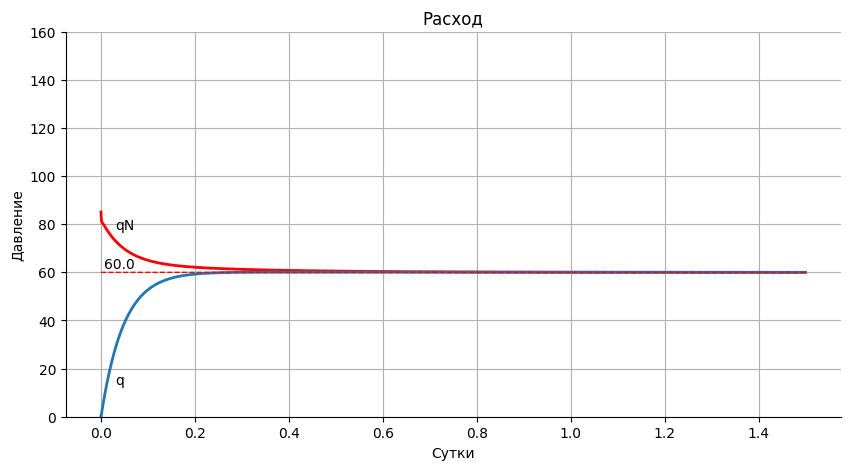

In [306]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'], df['q_N'], 'r', lw=2)
plt.plot(df['x'], df['q'], lw=2)
plt.plot(df['x'], [df['q'][k-1]]*k,'r--', lw=1)


# set x label
plt.xlabel('Сутки')
plt.ylabel('Давление')

# set title
plt.title('Расход')


plt.ylim(0, 160)
plt.grid(True)

plt.annotate('q', xy = (df['x'][500],df['q'][200] ))
plt.annotate('qN', xy = (df['x'][500],df['q_N'][200] ))
plt.annotate(df['q_N'][k-1].round(1), xy = (df['x'][100], df['q_N'][k-1]*1.03 ))
# display plot
plt.show()


In [307]:
df['q_N']

,q_N
0,85.119186
1,84.682898
2,84.291084
3,83.939074
4,83.622692
...,...
24995,60.007909
24996,60.007907
24997,60.007905
24998,60.007903


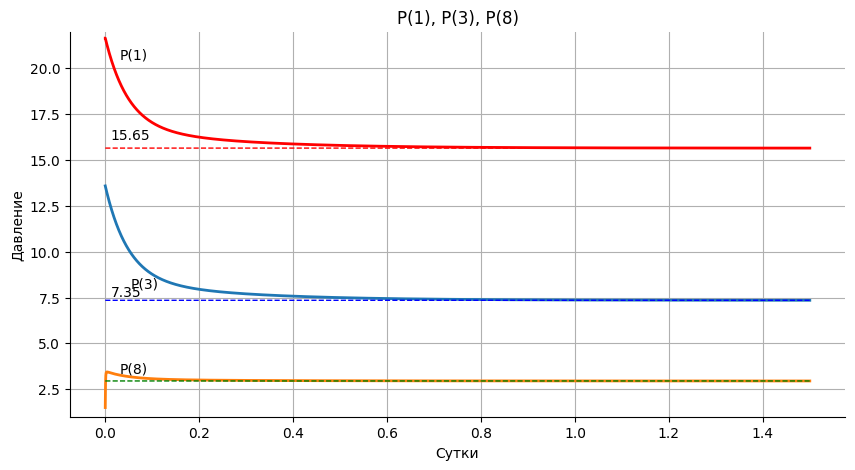

In [308]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one


plt.plot(df['x'], df['p_1'],'r', lw=2)
plt.plot(df['x'], [df['p_1'][k-1]]*k,'r--', lw=1)

plt.plot(df['x'], df['p_3'], lw=2)
plt.plot(df['x'], [df['p_3'][k-1]]*k,'b--', lw=1)

plt.plot(df['x'], df['p_8'], lw=2)
plt.plot(df['x'], [df['p_8'][k-1]]*k,'g--', lw=1)


# set x label
plt.xlabel('Сутки')
plt.ylabel('Давление')

# set title
plt.title('P(1), P(3), P(8)')


plt.ylim(1, 22)
plt.grid(True)
plt.annotate('P(1)', xy = (df['x'][500],df['p_1'][200] ))
plt.annotate(str(df['p_1'][k-1].round(2)), xy = (df['x'][200], df['p_1'][k-1]*1.03))

plt.annotate('P(3)', xy = (df['x'][900],8 ))
plt.annotate(str(df['p_3'][k-1].round(2)), xy = (df['x'][200], df['p_3'][k-1]*1.03))


plt.annotate('P(8)', xy = (df['x'][500],df['p_8'][200] ))
#plt.annotate(str(df['p_8'][14999].round(2)), xy = (df['x'][200], df['p_8'][14999]*1.03))

# display plot
plt.show()

In [309]:
str(df['p_1'][k-1].round(2))

'15.65'

In [310]:
df.iloc[14999]

,14999
q_N,60.097825
p_3,7.375992
p_1,15.677843
q,60.010942
h_4,727.010002
u,1.000000
x,0.899976
p_4,1.516291
p_8,2.953171


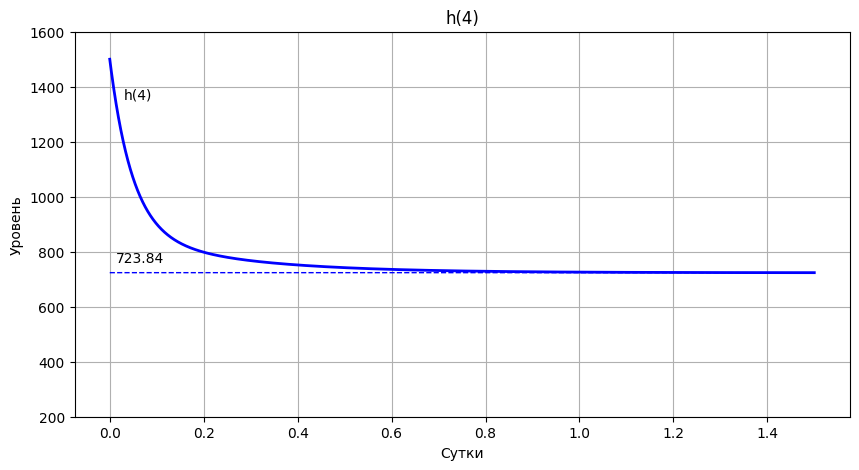

In [311]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(df['x'], df['h_4'],'b', lw=2)
plt.plot(df['x'], [df['h_4'][k-1]]*k,'b--', lw=1)

plt.annotate('h(4)', xy = (df['x'][500],df['h_4'][200] ))
plt.annotate(str(df['h_4'][k-1].round(2)), xy = (df['x'][200], df['h_4'][k-1]*1.05))

# set x label
plt.xlabel('Сутки')
plt.ylabel('Уровень')

# set title
plt.title('h(4)')
plt.ylim(200, 1600)
plt.grid(True)
plt.show()